In [1]:
import rasterio as rio
from rasterio import mask
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling

import numpy as np

import boto3
import s3fs
from IPython import display
import skimage
from sklearn import metrics

from io import BytesIO
import base64

import mercantile
from tqdm import tqdm

import sys
sys.path.append("../model/robosat_pink/")
from robosat_pink import datasets

from shapely import geometry
from functools import partial
import pyproj
from shapely.ops import transform

import re
import os 
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

import matplotlib.pyplot as plt
%matplotlib inline

# Analysis of Accuracy of Predictions

In [2]:
aws_session = boto3.Session(profile_name = 'esip')

**Scope**: Predictions from a single ASO collect from Tuolumne, 20180528. 

In [3]:
fs = s3fs.S3FileSystem(session = aws_session)
predictions =  [d.split('/')[1] for d in fs.ls('planet-snowcover-predictions') if re.match(".*20180528.*_clip", d)]

We'll pair these predictions with ASO.

In [4]:
aso = datasets.S3SlippyMapTiles("s3://planet-snowcover-snow/{}".format("ASO_3M_SD_USCATE_20180528_binary"), mode='multibands', aws_profile='esip')
display.Markdown("{} ASO Tiles".format(len(aso)))

1983 ASO Tiles

In [5]:
def plot3(image, pred, mask, tile, ax = None):
#     fig.suptitle(tile)
    ax[0].imshow(image)
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[0].set_title("RGB (Planet, ~3m)")

    #     ax[0].set_title(tile)
    ax[1].imshow(mask)
    ax[1].set_title('ASO Observation')
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
#     ax[1].set_title("mask")
    ax[2].imshow(pred, cmap='cividis')#, vmin = 0, vmax = )
    ax[2].set_title("ML Prediction")
    ax[2].set_xticklabels([])
    ax[2].set_yticklabels([])
#     ax[2].set_title('prediction')
#     ax[3].imshow((pred > 0.0) - mask, cmap='seismic')

#     ax[2].set_title(mets
    ax[3].imshow(mask - pred, cmap='bwr')
    ax[3].set_title("Mask - Pred")
    ax[3].set_xticklabels([])
    ax[3].set_yticklabels([])
        

#     plt.colorbar(diff, ax = ax[3])
    # NDSI = 1-4 / 1 + 4
#    plt.colorbar(pred, ax  = ax[2], orientation='horizontal')


In [6]:
htmlTemplate = """
<!doctype html>

<html lang="en">
<head>
  <meta charset="utf-8">

  <title>{source}</title>

</head>

<body>
<h2>Source Image: {source}</h2>
<h2>Mean F1 (no zero tiles): {f1}</h2>
<h2>Mean Accuracy: {acc}</h2>
{content}
</body>
</html>
"""
imgTemplate =  '<p><img src=\'data:image/png;base64,{}\'></p>'


In [7]:
encodedImages = []
f1_scores = []
acc_scores = []
TNs, FNs, TPs, FPs = [], [], [], []
for pred in predictions[8:]:
    pred_tiles = datasets.S3SlippyMapTiles("s3://planet-snowcover-predictions/"+pred, 'multibands', aws_profile='esip', ext='tif') ## only TIF predictions wanted here.
    image_tiles = datasets.S3SlippyMapTiles("s3://planet-snowcover-imagery/"+pred, 'multibands', aws_profile='esip')
    print(len(pred_tiles))
    for p_t, i_t in tqdm(zip(pred_tiles, image_tiles), total = len(pred_tiles)):
        tile = p_t[0]
        asoTileLoc = "s3://planet-snowcover-snow/{}/{}/{}/{}.tif".format("ASO_3M_SD_USCATE_20180528_binary", tile.z, tile.x, tile.y)
        try: 
            with rio.Env(profile_name='esip'):
                asoTile = rio.open(asoTileLoc)
        except rio.RasterioIOError as e: 
            print(e)
            continue
        fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))
        rgb = np.moveaxis(i_t[1][[2, 1, 0]].numpy(), 0, 2)
        rgb = skimage.exposure.rescale_intensity(skimage.exposure.equalize_adapthist(rgb), in_range = (0, .62))
        plot3(rgb, p_t[1].squeeze().numpy(), asoTile.read().squeeze(), tile, ax)
       
        aso_pix = asoTile.read().squeeze().flatten()
        aso_all_zero = (aso_pix == 0).all()
        pred_pix = p_t[1].squeeze().flatten().numpy().astype(aso_pix.dtype)

        f1 = metrics.f1_score(aso_pix, pred_pix)
        acc = metrics.accuracy_score(aso_pix, pred_pix)
        f1_scores.append((f1, aso_all_zero))
        acc_scores.append(acc)
                         
        fig.suptitle("{}, F1: {:.2f} Acc: {:.2f}".format(tile, f1, acc))

        tmpfile = BytesIO()
        fig.savefig(tmpfile, format='png', bbox_inches='tight')     
        encoded = base64.b64encode(tmpfile.getvalue())
        encodedImages.append(encoded)
        plt.close()
        
        CM = metrics.confusion_matrix(aso_pix, pred_pix)
        
        if CM.shape != (2,2): continue

        TNs.append(CM[0][0])
        FNs.append(CM[1][0])
        TPs.append(CM[1][1])
        FPs.append(CM[0][1])
        
    break

  0%|          | 0/189 [00:00<?, ?it/s]

189


  1%|          | 1/189 [00:01<03:24,  1.09s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5486/12652.tif' does not exist in the file system, and is not recognized as a supported dataset name.


  1%|          | 2/189 [00:01<02:22,  1.32it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5486/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


  2%|▏         | 3/189 [00:01<01:53,  1.63it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5486/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


/home/ubuntu/anaconda3/envs/pytorch_p36_2/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ubuntu/anaconda3/envs/pytorch_p36_2/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
  4%|▎         | 7/189 [00:06<02:46,  1.10it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5487/12651.tif' does not exist in the file system, and is not recognized as a supported dataset name.


  4%|▍         | 8/189 [00:06<02:32,  1.19it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5487/12652.tif' does not exist in the file system, and is not recognized as a supported dataset name.


  5%|▍         | 9/189 [00:07<02:23,  1.25it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5487/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


  5%|▌         | 10/189 [00:07<02:16,  1.31it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5487/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


  9%|▉         | 17/189 [00:15<02:41,  1.06it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5488/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 10%|▉         | 18/189 [00:16<02:36,  1.09it/s]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5488/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 13%|█▎        | 25/189 [00:25<02:48,  1.02s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5489/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 15%|█▍        | 28/189 [00:29<02:50,  1.06s/it]/home/ubuntu/anaconda3/envs/pytorch_p36_2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
 16%|█▋        | 31/189 [00:32<02:45,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5490/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 17%|█▋        | 32/189 [00:32<02:41,  1.03s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5490/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 20%|██        | 38/189 [00:40<02:42,  1.08s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5491/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 21%|██        | 39/189 [00:41<02:38,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5491/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 21%|██        | 40/189 [00:41<02:34,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5491/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 24%|██▍       | 46/189 [00:48<02:31,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5492/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 25%|██▍       | 47/189 [00:49<02:28,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5492/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 25%|██▌       | 48/189 [00:49<02:26,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5492/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 29%|██▉       | 55/189 [00:58<02:21,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5493/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 30%|██▉       | 56/189 [00:58<02:19,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5493/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 33%|███▎      | 62/189 [01:06<02:15,  1.07s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5494/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 33%|███▎      | 63/189 [01:06<02:12,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5494/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 37%|███▋      | 69/189 [01:13<02:08,  1.07s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5495/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 37%|███▋      | 70/189 [01:14<02:05,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5495/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 38%|███▊      | 71/189 [01:14<02:03,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5495/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 41%|████      | 77/189 [01:21<01:59,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5496/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 41%|████▏     | 78/189 [01:22<01:57,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5496/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 42%|████▏     | 79/189 [01:22<01:55,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5496/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 45%|████▍     | 85/189 [01:30<01:50,  1.07s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5497/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 46%|████▌     | 86/189 [01:31<01:48,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5497/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 46%|████▌     | 87/189 [01:31<01:47,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5497/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 49%|████▊     | 92/189 [01:37<01:42,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5498/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 49%|████▉     | 93/189 [01:37<01:40,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5498/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 50%|████▉     | 94/189 [01:38<01:39,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5498/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 52%|█████▏    | 98/189 [01:43<01:35,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5499/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 52%|█████▏    | 99/189 [01:43<01:33,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5499/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 53%|█████▎    | 100/189 [01:43<01:32,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5499/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 53%|█████▎    | 101/189 [01:44<01:30,  1.03s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5499/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 56%|█████▌    | 105/189 [01:48<01:26,  1.03s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5500/12653.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 56%|█████▌    | 106/189 [01:49<01:25,  1.03s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5500/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 57%|█████▋    | 107/189 [01:49<01:23,  1.02s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5500/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 57%|█████▋    | 108/189 [01:49<01:22,  1.02s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5500/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 58%|█████▊    | 109/189 [01:50<01:21,  1.01s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5500/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 60%|██████    | 114/189 [01:56<01:16,  1.02s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5501/12654.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 61%|██████    | 115/189 [01:57<01:15,  1.02s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5501/12655.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 61%|██████▏   | 116/189 [01:57<01:14,  1.02s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5501/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 62%|██████▏   | 117/189 [01:58<01:12,  1.01s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5501/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 66%|██████▌   | 124/189 [02:07<01:07,  1.03s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5502/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 66%|██████▌   | 125/189 [02:08<01:05,  1.03s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5502/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 69%|██████▉   | 131/189 [02:16<01:00,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5503/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 70%|██████▉   | 132/189 [02:16<00:59,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5503/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 73%|███████▎  | 138/189 [02:24<00:53,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5504/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 74%|███████▎  | 139/189 [02:24<00:52,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5504/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 77%|███████▋  | 145/189 [02:31<00:45,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5505/12656.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 77%|███████▋  | 146/189 [02:32<00:44,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5505/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 78%|███████▊  | 147/189 [02:32<00:43,  1.04s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5505/12658.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 81%|████████▏ | 154/189 [02:41<00:36,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5506/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 82%|████████▏ | 155/189 [02:42<00:35,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5506/12658.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 86%|████████▌ | 162/189 [02:50<00:28,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5507/12658.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 89%|████████▉ | 168/189 [02:57<00:22,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5508/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 89%|████████▉ | 169/189 [02:57<00:21,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5508/12658.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 93%|█████████▎| 175/189 [03:05<00:14,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5509/12657.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 93%|█████████▎| 176/189 [03:05<00:13,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5509/12658.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 94%|█████████▎| 177/189 [03:06<00:12,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5509/12659.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 97%|█████████▋| 184/189 [03:14<00:05,  1.06s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5510/12658.tif' does not exist in the file system, and is not recognized as a supported dataset name.


 98%|█████████▊| 185/189 [03:14<00:04,  1.05s/it]

'/vsis3/planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary/15/5510/12659.tif' does not exist in the file system, and is not recognized as a supported dataset name.


100%|██████████| 189/189 [03:22<00:00,  1.07s/it]


In [8]:
imgTags = [imgTemplate.format(e.decode('utf-8')) for e in encodedImages]

In [12]:
f1_score_nozero = np.mean([f[0] for f in f1_scores if not f[1]])
mean_acc = np.mean(acc_scores)

In [13]:
predictions[8]

'20180528_181113_1025_3B_AnalyticMS_SR_clip'

In [11]:
allImages = '\n'.join(imgTags)
html = htmlTemplate.format(source=predictions[8], content = allImages, f1 = f1_score_nozero, acc= )
with open('{}.html'.format(predictions[8]),'w') as f:
    f.write(html)

# F1

In [21]:
p_t[1].numpy().squeeze().shape

(512, 512)

In [22]:
from scipy import ndimage

In [72]:
p_t_resamp = ndimage.zoom(p_t[1].numpy().squeeze().astype('int'), zoom=0.5, order = 2)


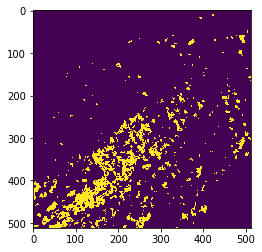

In [73]:
plt.imshow(asoTile.read().squeeze())


In [74]:
aso_resamp = ndimage.zoom(asoTile.read().squeeze(), zoom=0.5, order = 2)


In [75]:
metrics.f1_score(aso_pix, pred_pix)

0.438003120124805

In [76]:
metrics.f1_score(aso_resamp.flatten(), p_t_resamp.flatten())

0.4399098647971958

In [56]:
((aso_resamp.flatten() == 1) | (aso_resamp.flatten() == 0)).all()

True

In [67]:
((p_t[1].numpy().flatten() == 1) | (p_t[1].numpy().flatten() == 0)).all()

True

In [69]:
p_t_resamp

array([[-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.95954236e-42,  9.95905296e-29,  6.80944194e-27, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-3.12489558e-43,  1.45654715e-30,  9.95905296e-29, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 2.80259693e-45, -4.48415509e-44,  1.43492963e-42, ...,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00]], dtype=float32)

In [71]:
p_t[1].numpy().dtype

dtype('float32')

In [ ]:
FPs